--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BERLIN ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


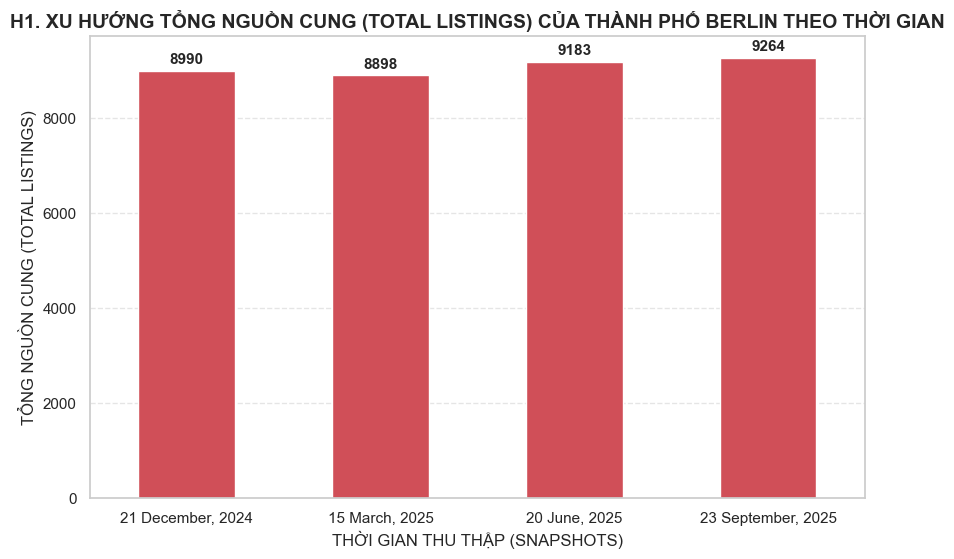

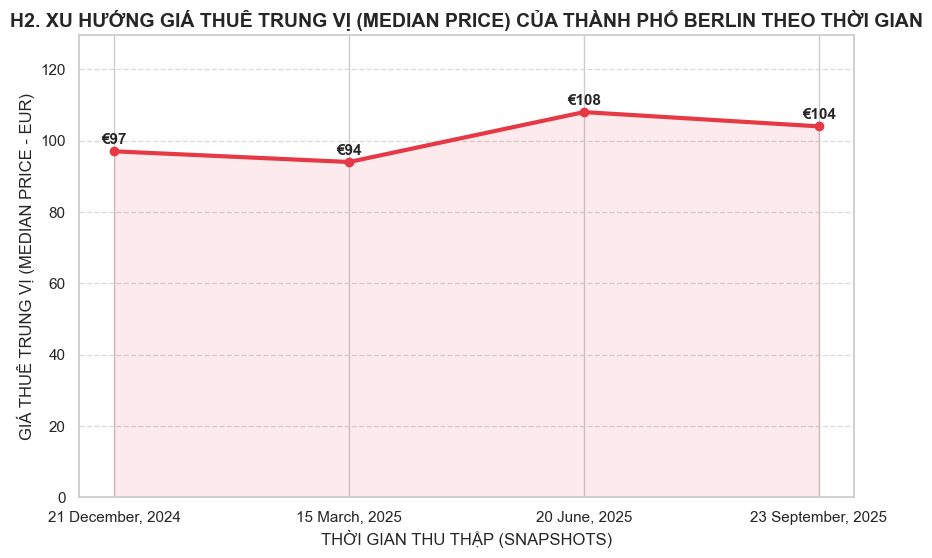

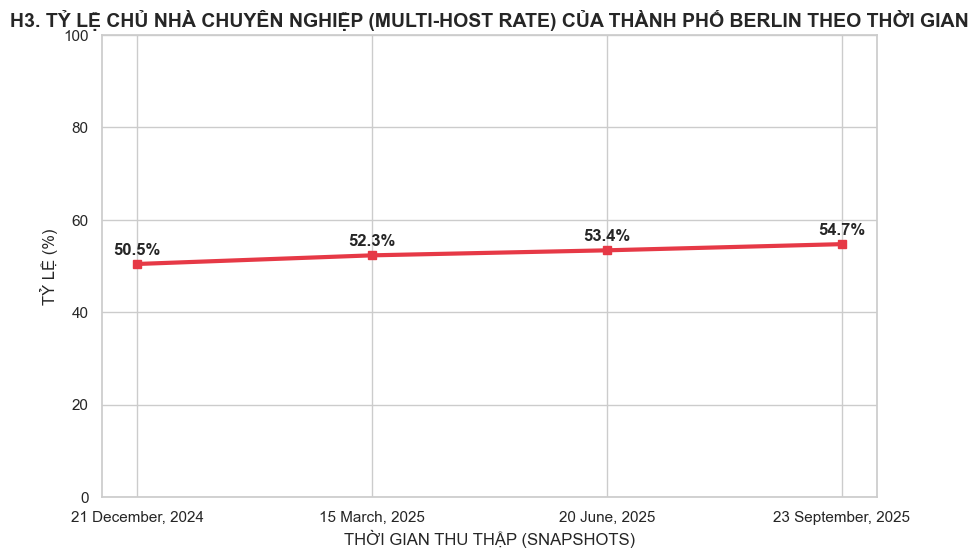

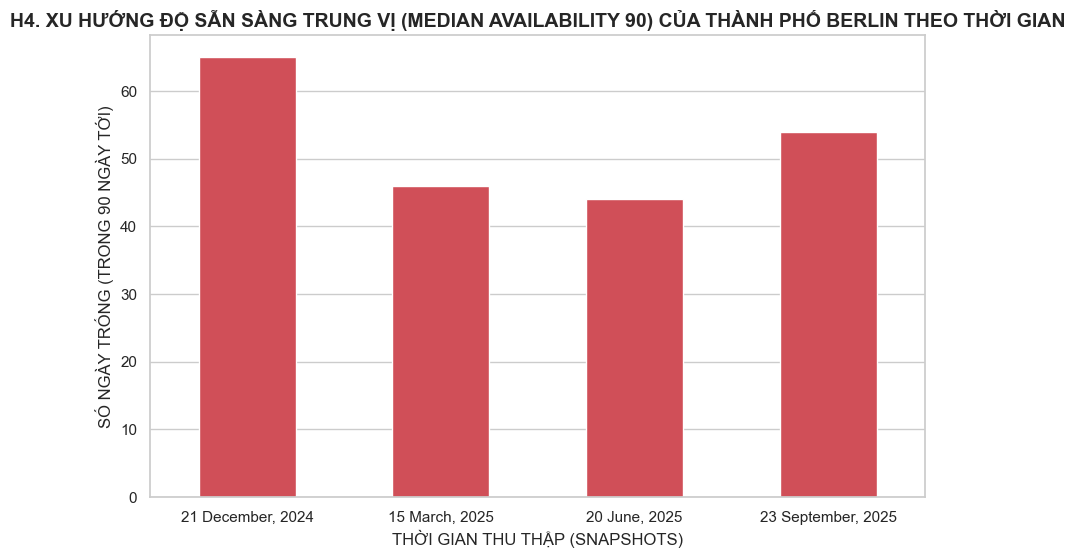

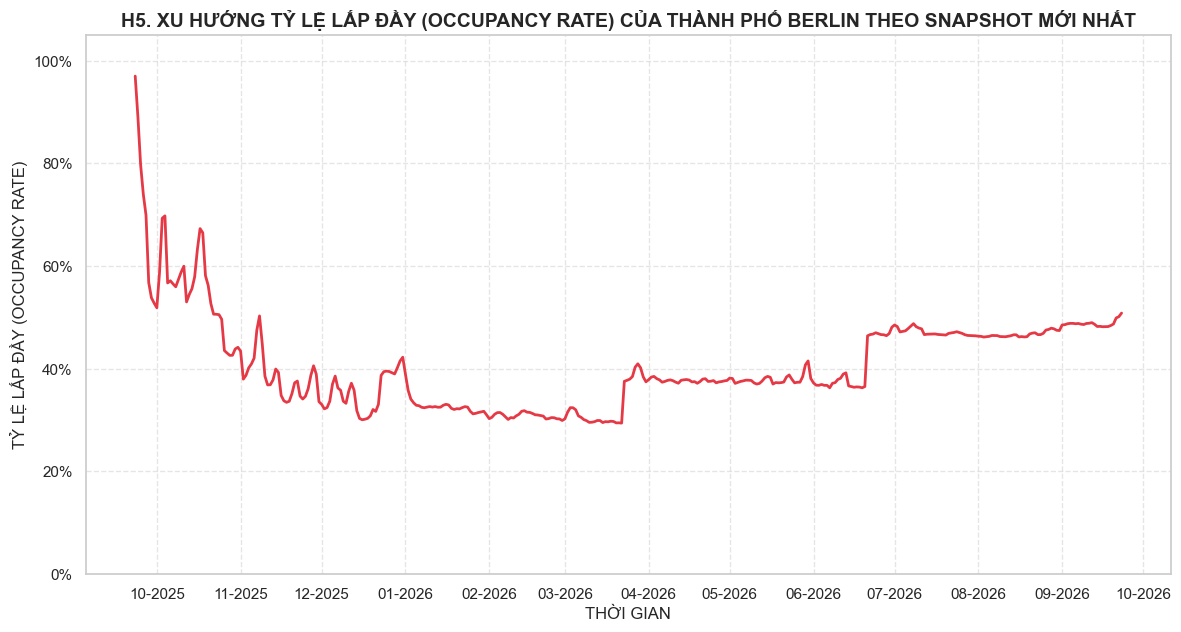

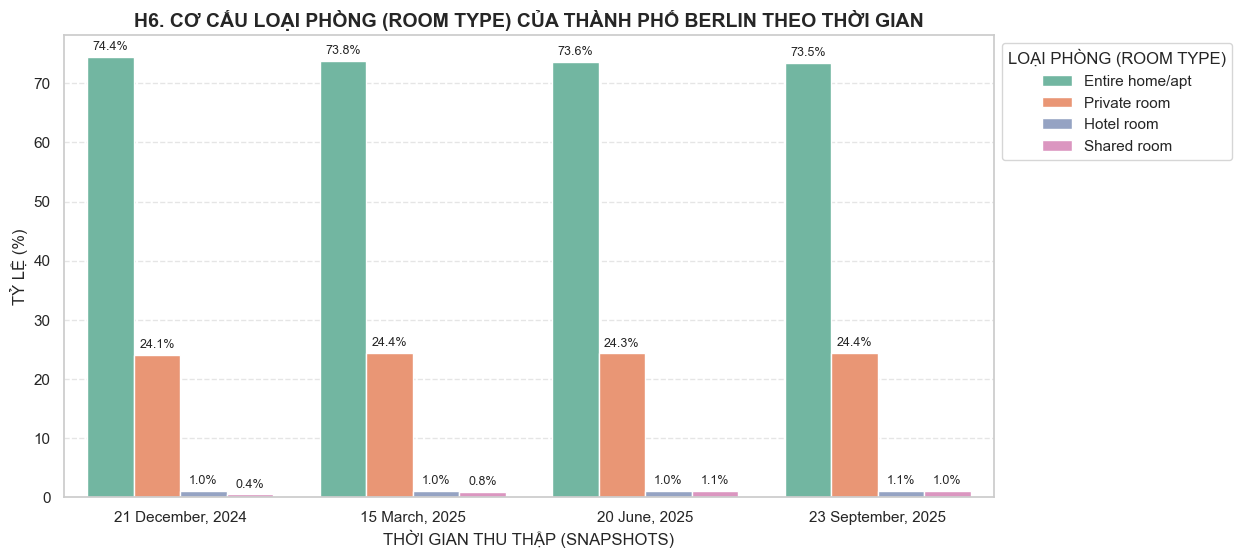

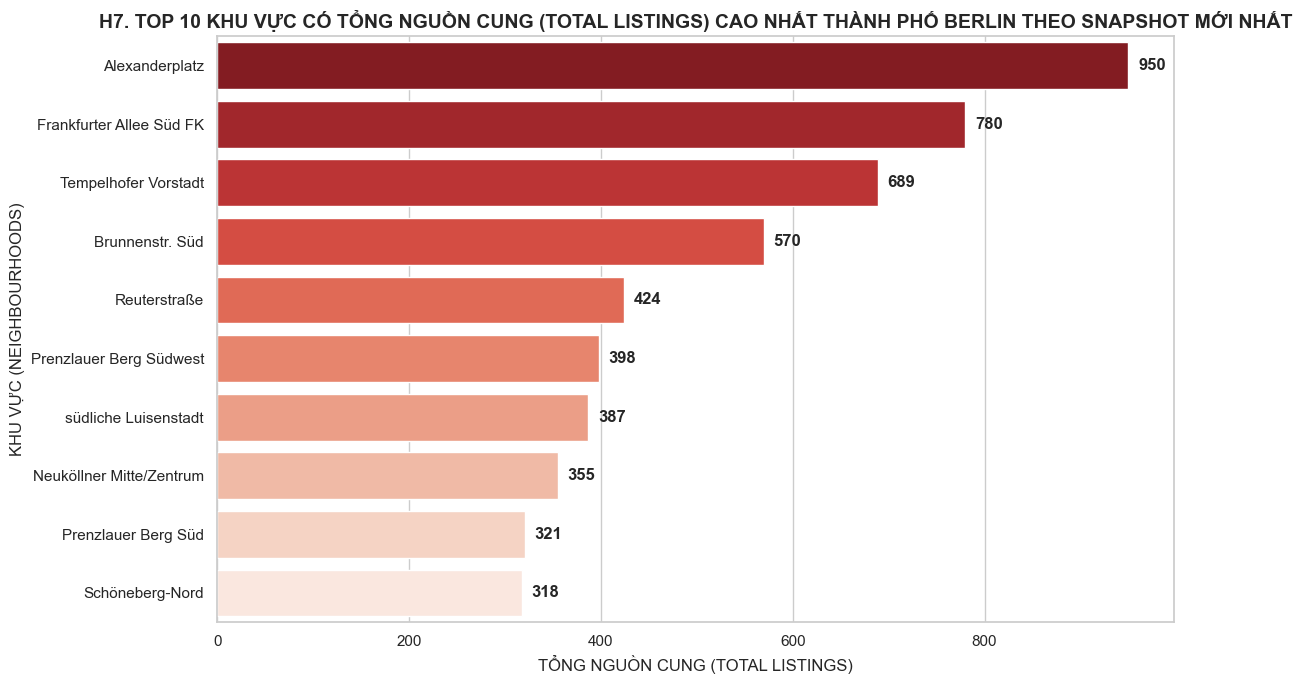

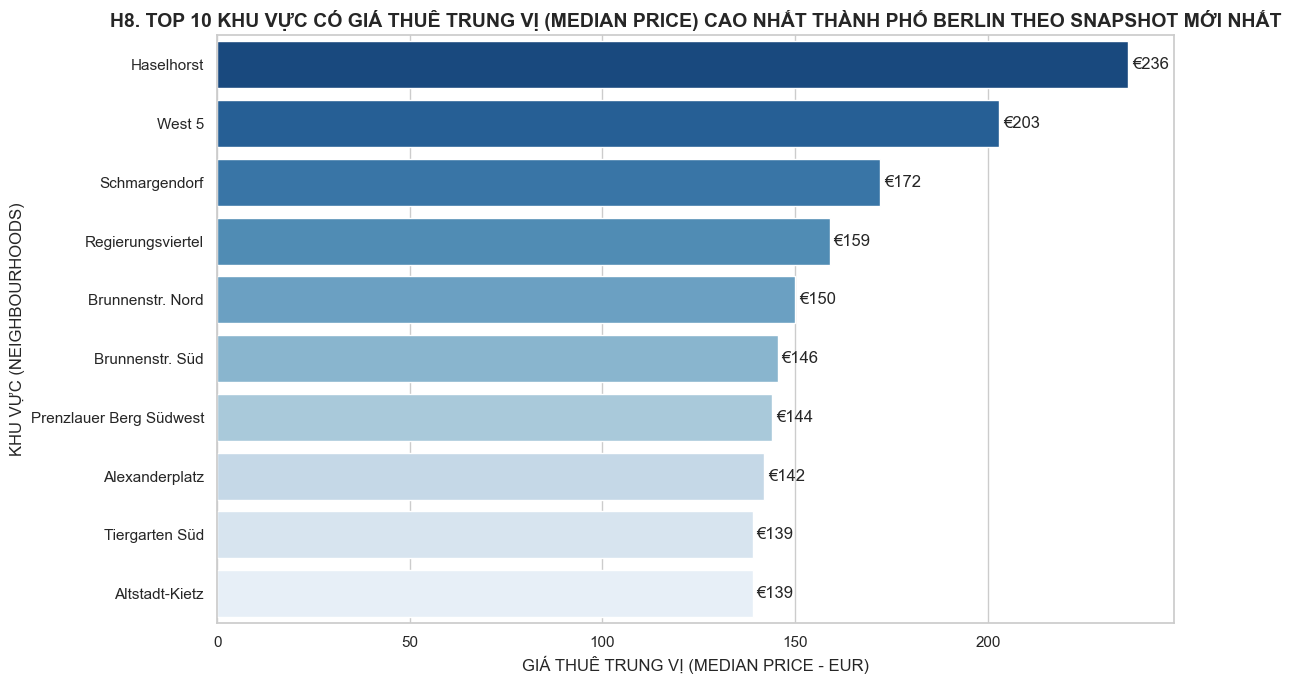

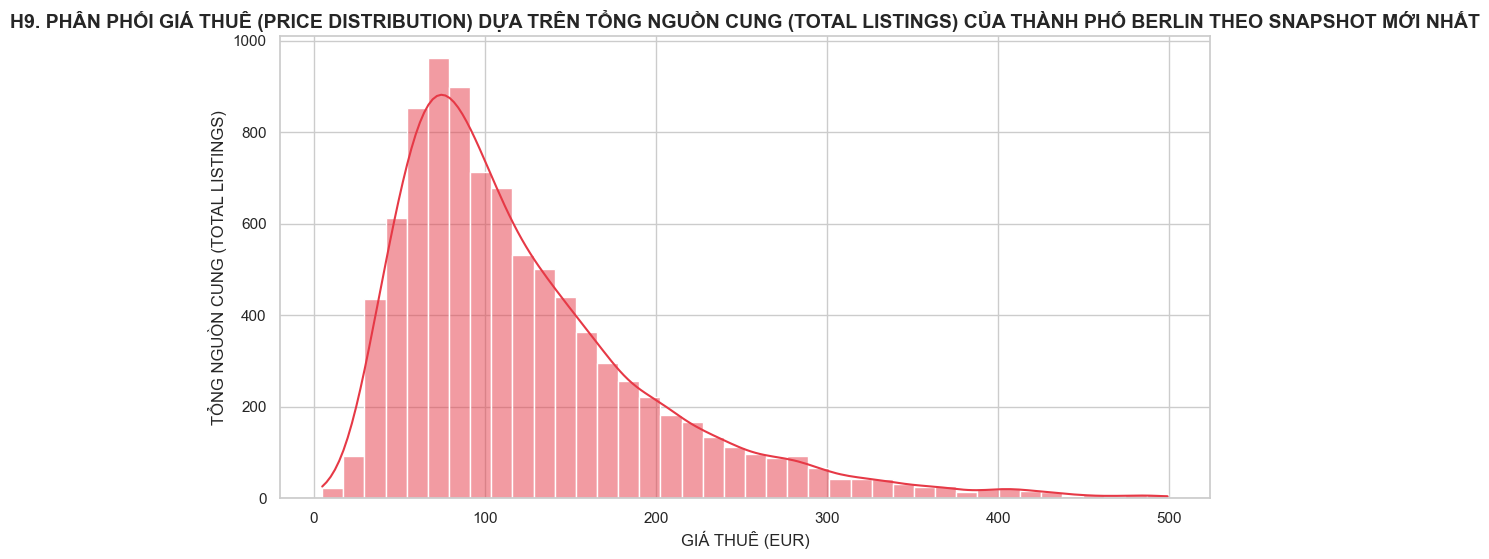

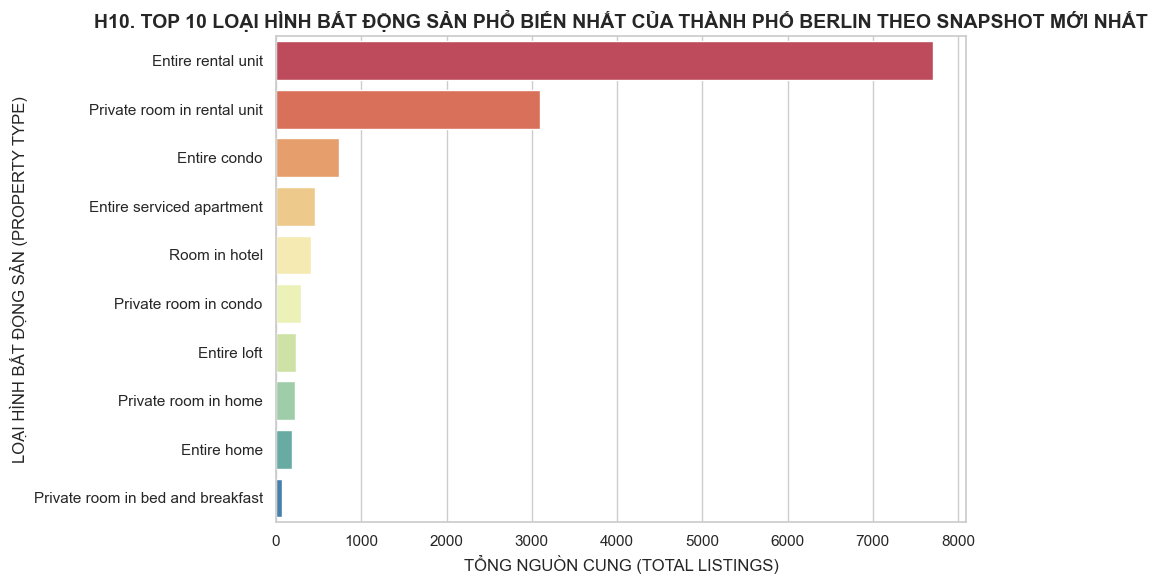

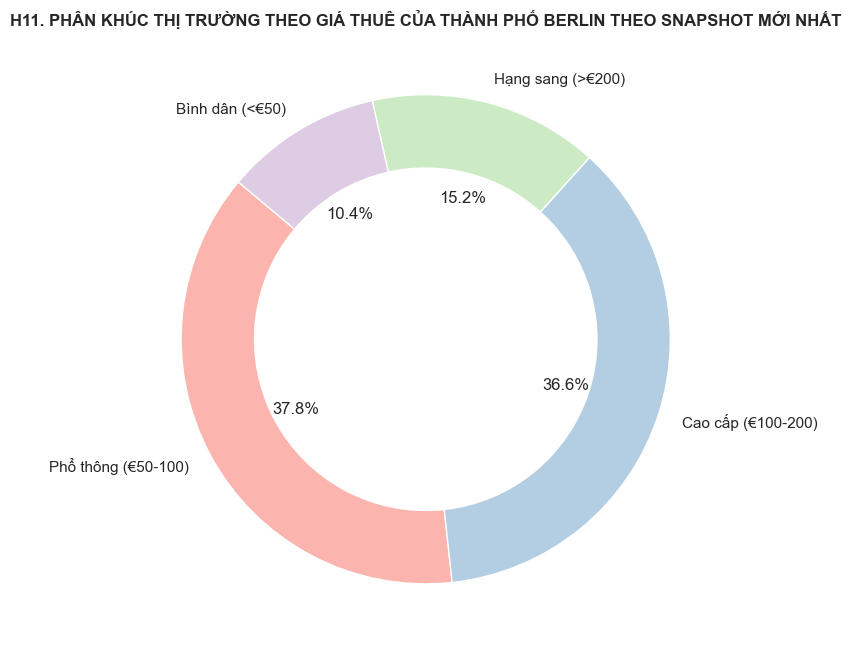

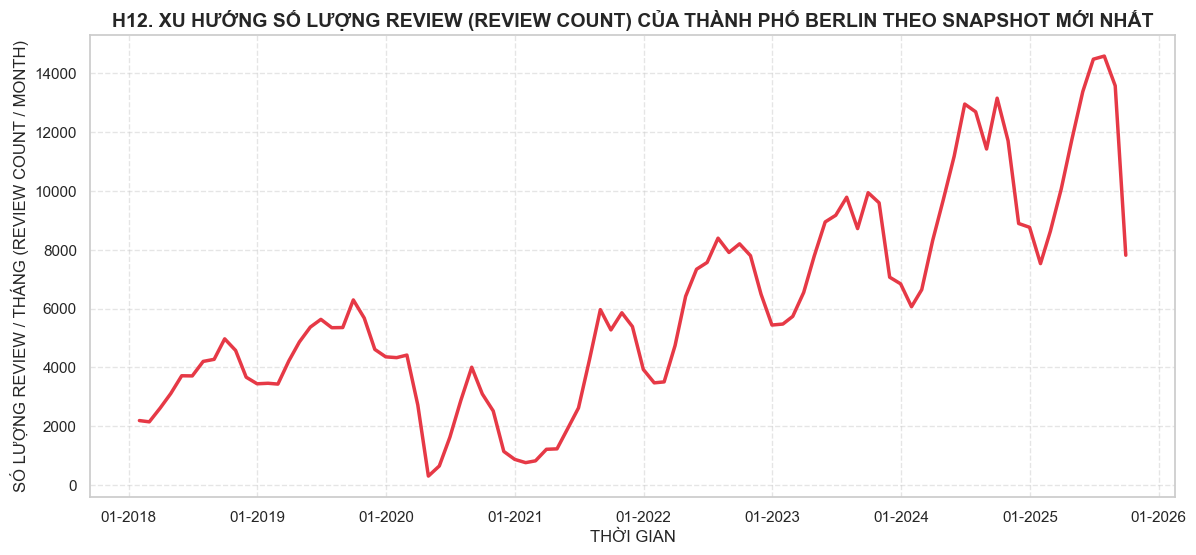

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

# --- 1. THIẾT LẬP ---
sns.set_theme(style="whitegrid")
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'berlin')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
CITY_SUFFIX = 'berlin'

print("--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BERLIN ---")

# --- 2. NẠP DỮ LIỆU KPI ---
try:
    kpi_supply = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_summary_general_{CITY_SUFFIX}.csv'))
    kpi_room = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_room_type_{CITY_SUFFIX}.csv'))
    kpi_season = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_seasonality_{CITY_SUFFIX}.csv'))
    # Load thêm 2 file mới
    kpi_neigh = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_neighbourhood_{CITY_SUFFIX}.csv'))
    kpi_review = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_reviews_trend_{CITY_SUFFIX}.csv'))
    
    # Sắp xếp thời gian
    kpi_supply['dt'] = pd.to_datetime(kpi_supply['snapshot_date'], errors='coerce')
    kpi_supply = kpi_supply.sort_values('dt')
    print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
except FileNotFoundError as e:
    print(f"⚠️ Thiếu file KPI: {e}")
    kpi_supply = pd.DataFrame(); kpi_room = pd.DataFrame(); kpi_season = pd.DataFrame()
    kpi_neigh = pd.DataFrame(); kpi_review = pd.DataFrame()


# --- 3. NẠP DỮ LIỆU CHI TIẾT ---
from datetime import datetime

def parse_snapshot_name(name):
    try:
        return datetime.strptime(name.strip(), "%d %B, %Y")
    except:
        return None

df_detail = pd.DataFrame()
LATEST_SNAPSHOT = "Unknown"

if os.path.exists(PROCESSED_DIR):
    raw_snaps = [
        d for d in os.listdir(PROCESSED_DIR)
        if os.path.isdir(os.path.join(PROCESSED_DIR, d))
    ]

    snapshots = [s for s in raw_snaps if parse_snapshot_name(s) is not None]
    snapshots = sorted(snapshots, key=lambda x: parse_snapshot_name(x), reverse=True)

    for snap in snapshots:
        file_path = os.path.join(PROCESSED_DIR, snap, 'listings_processed.csv')
        if os.path.exists(file_path):
            try:
                temp = pd.read_csv(file_path, low_memory=False)
                if not temp.empty and 'price_numeric' in temp.columns:
                    df_detail = temp
                    LATEST_SNAPSHOT = snap
                    break
            except: continue


# --- 4. VẼ BIỂU ĐỒ ---

# === H1: Xu hướng Nguồn Cung ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(data=kpi_supply, x='snapshot_date', y='total_listings', color='#E63946', width=0.5)
    plt.title('H1. XU HƯỚNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax1.containers: ax1.bar_label(i, padding=3, fontsize=11, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_01_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

# === H2: Xu hướng Giá ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['median_price'], marker='o', linewidth=3, color='#E63946')
    plt.fill_between(kpi_supply['snapshot_date'], kpi_supply['median_price'], color='#E63946', alpha=0.1)
    plt.title('H2. XU HƯỚNG GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['median_price']):
        plt.text(x, y + 2, f"€{y:.0f}", ha='center', fontsize=11, fontweight='bold')
    plt.ylim(bottom=0, top=kpi_supply['median_price'].max()*1.2)
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_02_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()


# === H3: Multi-Host Rate (Chủ nhà chuyên nghiệp) ===
if not kpi_supply.empty and 'multi_host_rate' in kpi_supply.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['multi_host_rate'], marker='s', linewidth=3, color='#E63946')
    plt.title(f'H3. TỶ LỆ CHỦ NHÀ CHUYÊN NGHIỆP (MULTI-HOST RATE) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN',fontsize = 14, fontweight='bold')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylabel('TỶ LỆ (%)')
    plt.ylim(0, 100)
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['multi_host_rate']):
        plt.text(x, y + 2, f"{y:.1f}%", ha='center', fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_03_multi_host.pdf'), bbox_inches='tight')
    plt.show()

# === H4: Độ sẵn sàng (Availability) ===
if not kpi_supply.empty and 'median_avail_90' in kpi_supply.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=kpi_supply, x='snapshot_date', y='median_avail_90', color='#E63946', width=0.5)
    plt.title(f'H4. XU HƯỚNG ĐỘ SẴN SÀNG TRUNG VỊ (MEDIAN AVAILABILITY 90) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN',fontsize = 14, fontweight='bold')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.ylabel('SỐ NGÀY TRỐNG (TRONG 90 NGÀY TỚI)')
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_04_availability.pdf'), bbox_inches='tight')
    plt.show()

# === H5: Occupancy ===
if not kpi_season.empty:
    df_h5 = kpi_season.copy()
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = pd.to_datetime(df_h5['snapshot_date'], errors='coerce')

    latest_snap_dt = df_h5['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5['snapshot_dt'] == latest_snap_dt].sort_values('date_dt')

    if not df_final_h5.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', color='#E63946', linewidth=2)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.title('H5. XU HƯỚNG TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
        plt.xlabel('THỜI GIAN')
        plt.ylabel('TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.ylim(0, 1.05)
        plt.savefig(os.path.join(FIGURES_DIR, 'berlin_05_occupancy.pdf'), format='pdf', bbox_inches='tight')
        plt.show()


# === H6: Cơ cấu Loại phòng (Grouped Bar) ===
if not kpi_room.empty:
    plt.figure(figsize=(12, 6))
    kpi_room['dt'] = pd.to_datetime(kpi_room['snapshot_date'], errors='coerce')
    kpi_room = kpi_room.sort_values('dt')
    
    ax3 = sns.barplot(data=kpi_room, x='snapshot_date', y='percentage', hue='room_type', palette='Set2')
    plt.title('H6. CƠ CẤU LOẠI PHÒNG (ROOM TYPE) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.legend(title='LOẠI PHÒNG (ROOM TYPE)', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax3.containers: ax3.bar_label(i, fmt='%.1f%%', padding=3, fontsize=9)
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_06_room_type.pdf'), format='pdf', bbox_inches='tight')
    plt.show()




    
# === H7: Top 10 khu vực nhiều listing nhất ===
if not df_detail.empty:
    top_supply = df_detail['neighbourhood_cleansed'].value_counts().head(10).reset_index()
    top_supply.columns = ['neighbourhood_cleansed', 'count']

    plt.figure(figsize=(12, 7))
    sns.barplot(data=top_supply, y='neighbourhood_cleansed', x='count', 
                hue='neighbourhood_cleansed', palette='Reds_r', legend=False)
    plt.title('H7. TOP 10 KHU VỰC CÓ TỔNG NGUỒN CUNG (TOTAL LISTINGS) CAO NHẤT THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    for i, v in enumerate(top_supply['count']):
        plt.text(v + 10, i, f"{v}", va='center', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_07_top10_supply.pdf'))
    plt.show()


# === H8: Top 10 khu vực đắt nhất ===
if not df_detail.empty:
    neigh_price = df_detail.groupby('neighbourhood_cleansed')['price_numeric'].median().sort_values(ascending=False).head(10).reset_index()

    plt.figure(figsize=(12, 7))
    sns.barplot(data=neigh_price, y='neighbourhood_cleansed', x='price_numeric', 
                hue='neighbourhood_cleansed', palette='Blues_r', legend=False)
    plt.title('H8. TOP 10 KHU VỰC CÓ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CAO NHẤT THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    for i, v in enumerate(neigh_price['price_numeric']):
        plt.text(v + 1, i, f"€{v:.0f}", va='center')
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_08_top10_price.pdf'))
    plt.show()


# === H9: Histogram giá ===
if not df_detail.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(df_detail[df_detail['price_numeric'] < 500]['price_numeric'], kde=True, bins=40, color='#E63946')
    plt.title('H9. PHÂN PHỐI GIÁ THUÊ (PRICE DISTRIBUTION) DỰA TRÊN TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ (EUR)')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_09_price_distribution.pdf'), format='pdf', bbox_inches='tight')
    plt.show()






# === H10: Top 10 Loại hình Bất động sản  ===
if not df_detail.empty and 'property_type' in df_detail.columns:
    top_props = df_detail['property_type'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_props.index, x=top_props.values, 
                hue=top_props.index, palette='Spectral', legend=False)
    plt.title('H10. TOP 10 LOẠI HÌNH BẤT ĐỘNG SẢN PHỔ BIẾN NHẤT CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.ylabel('LOẠI HÌNH BẤT ĐỘNG SẢN (PROPERTY TYPE)')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_10_property_type.pdf'))
    plt.show()



# === H11: Phân khúc Giá (Donut Chart) ===
if not df_detail.empty:
    plt.figure(figsize=(8, 8))
    bins = [0, 50, 100, 200, 10000]
    labels = ['Bình dân (<€50)', 'Phổ thông (€50-100)', 'Cao cấp (€100-200)', 'Hạng sang (>€200)']
    df_detail['price_segment'] = pd.cut(df_detail['price_numeric'], bins=bins, labels=labels)
    seg_counts = df_detail['price_segment'].value_counts()
    
    plt.pie(seg_counts, labels=seg_counts.index, autopct='%1.1f%%', startangle=140, 
            colors=sns.color_palette('Pastel1'), wedgeprops=dict(width=0.3))
    plt.title('H11. PHÂN KHÚC THỊ TRƯỜNG THEO GIÁ THUÊ CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_11_price_segments.pdf'))
    plt.show()


# === H12: XU HƯỚNG LƯỢNG REVIEW (NHU CẦU DU LỊCH) ===
if not kpi_review.empty:
    plt.figure(figsize=(14, 6))
    
    # 1. Tìm snapshot mới nhất (Logic chuẩn xác nhất)
    kpi_review['snap_dt'] = pd.to_datetime(kpi_review['snapshot_date'], errors='coerce')
    latest_snap_date = kpi_review['snap_dt'].max()
    
    # 2. Chỉ lọc lấy dữ liệu review của snapshot đó
    df_rev_final = kpi_review[kpi_review['snap_dt'] == latest_snap_date].copy()
    
    # 3. Xử lý ngày tháng
    df_rev_final['date'] = pd.to_datetime(df_rev_final['date'])
    df_rev_final = df_rev_final.sort_values('date')
    
    # 4. Lọc năm (2018 trở lại)
    df_rev_final = df_rev_final[df_rev_final['date'].dt.year >= 2018]

    # 5. Vẽ
    sns.lineplot(data=df_rev_final, x='date', y='review_count', color='#E63946', linewidth=2.5)
    
    plt.title(f'H12. XU HƯỚNG SỐ LƯỢNG REVIEW (REVIEW COUNT) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.ylabel('SỐ LƯỢNG REVIEW / THÁNG (REVIEW COUNT / MONTH)')
    plt.xlabel('THỜI GIAN')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_12_reviews_trend.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Không có dữ liệu Review Trend để vẽ H12.")


